## IMPORT LIB

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [34]:
from catboost import CatBoostClassifier
from catboost import Pool, cv


## IMPORT DATA

In [7]:
train_df = pd.read_csv("training_set_features.csv", index_col = 'respondent_id')
train_labels_df = pd.read_csv("training_set_labels.csv", index_col = 'respondent_id')
test_df = pd.read_csv("test_set_features.csv", index_col = 'respondent_id')
joined_df = train_df.join(train_labels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## FILLNaN and PREPROCESING

In [8]:
numeric_cols = train_df.select_dtypes('number').columns
categorical_cols = ['race', 'sex', 'marital_status', 'rent_or_own', 'hhs_geo_region','census_msa', 'employment_industry', 'employment_occupation']
ordered_cols = ['age_group', 'education', 'income_poverty', 'employment_status']

<Axes: ylabel='respondent_id'>

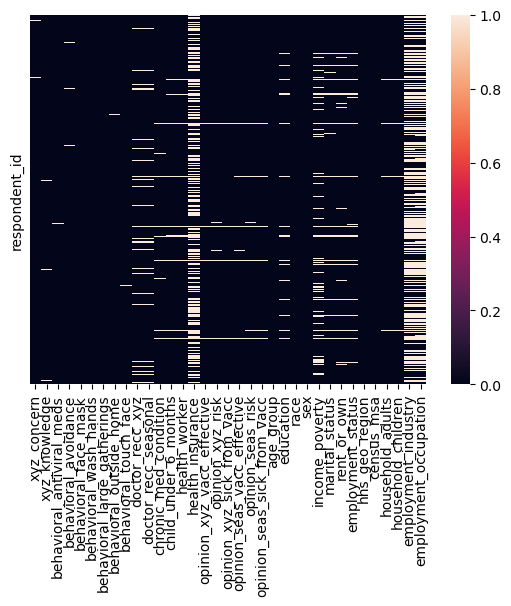

In [10]:
sns.heatmap(train_df.isnull(), yticklabels=False, xticklabels = train_df.columns)

<Axes: ylabel='respondent_id'>

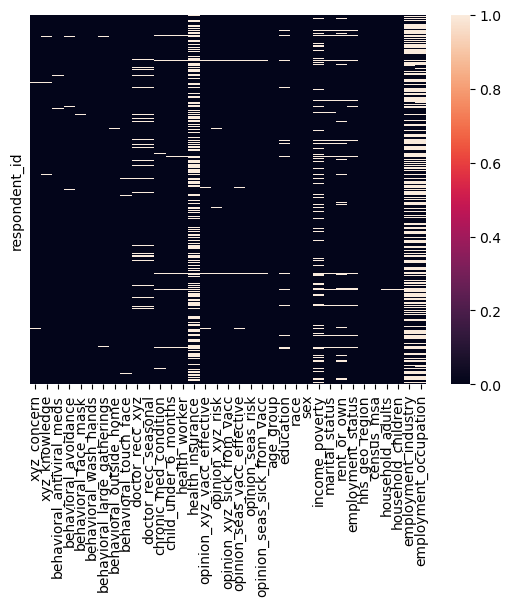

In [11]:
sns.heatmap(test_df.isnull(), yticklabels=False, xticklabels = test_df.columns)

In [13]:
for i in numeric_cols:
    train_df[i] = train_df[i].fillna(value = -1)
    test_df[i] = test_df[i].fillna(value = -1)

for i in (categorical_cols + ordered_cols):
    train_df[i] = train_df[i].fillna(value = 'missing')
    test_df[i] = test_df[i].fillna(value = 'missing')


<Axes: ylabel='respondent_id'>

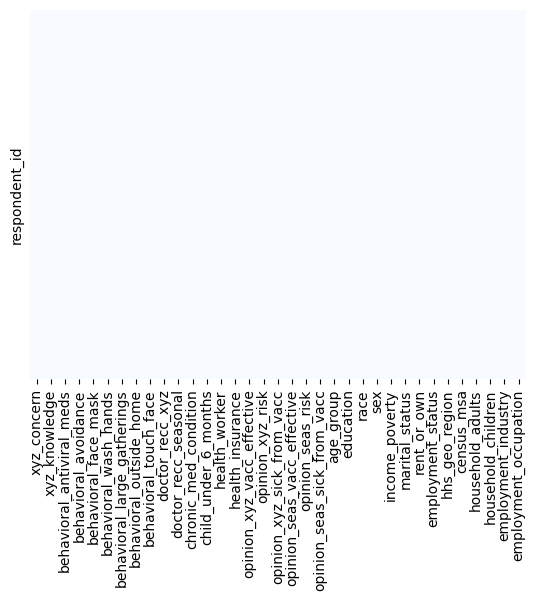

In [15]:
sns.heatmap(train_df.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels = train_df.columns)

<Axes: ylabel='respondent_id'>

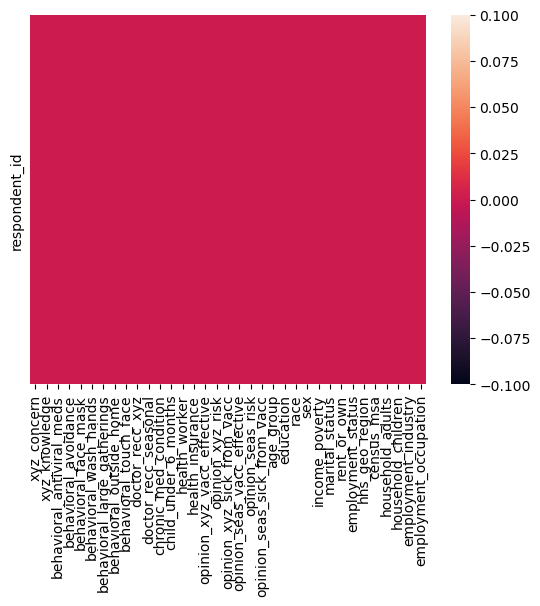

In [16]:
sns.heatmap(test_df.isnull(), yticklabels=False, xticklabels = test_df.columns)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_labels_df, test_size = 0.3, random_state = 68)


categorical_features_indices = np.where(X_train.dtypes != float)[0]
categorical_features_indices

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34], dtype=int64)

## APPLY ALOGORITHM

In [35]:
model_xyz = CatBoostClassifier(verbose = False,
                               cat_features = categorical_features_indices,
                               iterations = 500, 
                               learning_rate = 0.05745075659543725, 
                               random_strength = 4, 
                               bagging_temperature = 8, 
                               max_bin = 5, 
                               grow_policy = 'Lossguide', 
                               min_data_in_leaf = 7, 
                               max_depth = 6, 
                               l2_leaf_reg = 11.323094517862078, 
                               one_hot_max_size = 10, 
                               auto_class_weights = 'Balanced')
model_xyz.fit(X_train, y_train.xyz_vaccine)
pred_xyz = model_xyz.predict_proba(X_test)
pred_xyz = pred_xyz[:, 1].reshape(-1, 1)

In [36]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color = 'grey', linestyle = '--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

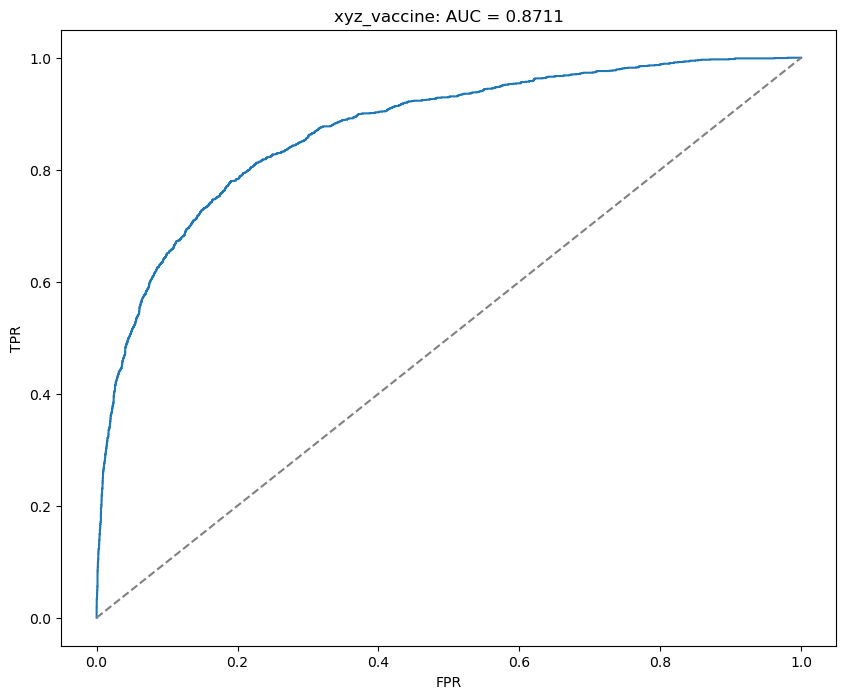

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot_roc(y_test['xyz_vaccine'],
        pred_xyz,
        'xyz_vaccine',
        ax = ax)

In [38]:
roc_auc_score(y_test.xyz_vaccine, pred_xyz)

0.8710964730481472

In [39]:
model_seasonal = CatBoostClassifier(verbose = False, 
                                    cat_features = categorical_features_indices,
                                    iterations = 1500, 
                                    learning_rate = 0.015393853845985255, 
                                    random_strength = 3, 
                                    bagging_temperature = 7, 
                                    max_bin = 8, 
                                    grow_policy = 'Lossguide', 
                                    min_data_in_leaf = 1, 
                                    max_depth = 5, 
                                    l2_leaf_reg = 0.03977425239611938, 
                                    one_hot_max_size = 500, 
                                    auto_class_weights = 'Balanced')
model_seasonal.fit(X_train, y_train.seasonal_vaccine)
pred_seasonal = model_seasonal.predict_proba(X_test)
pred_seasonal = pred_seasonal[:, 1].reshape(-1, 1)

0.86620519024171

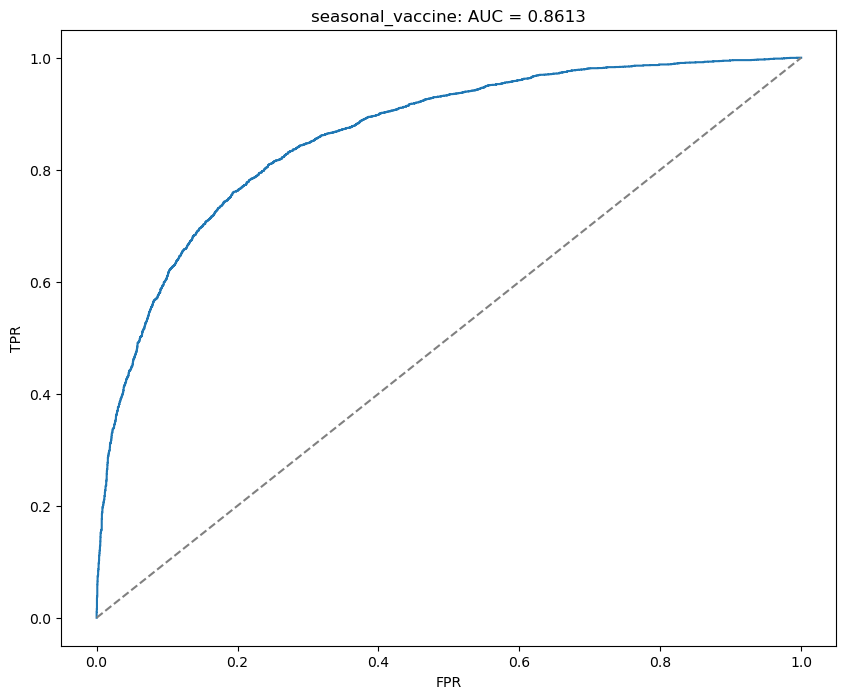

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'], 
    pred_seasonal, 
    'seasonal_vaccine',
    ax = ax
)
roc_auc_score(y_test.seasonal_vaccine, pred_seasonal)
roc_auc_score(y_test, np.hstack((pred_xyz, pred_seasonal)))

## submission file

In [41]:
model_xyz.fit(train_df, train_labels_df.xyz_vaccine)
final_xyz = model_xyz.predict_proba(test_df)
final_xyz = final_xyz[:, 1].reshape(-1, 1)

In [42]:
model_seasonal.fit(train_df, train_labels_df.seasonal_vaccine)
final_seasonal = model_seasonal.predict_proba(test_df)
final_seasonal = final_seasonal[:, 1].reshape(-1, 1)

In [47]:
submission_df = pd.read_csv("submission_format.csv", index_col = 'respondent_id', usecols = ['respondent_id', 'seasonal_vaccine'])
np.testing.assert_array_equal(test_df.index.values, 
                              submission_df.index.values)

submission_df["xyz_vaccine"] = final_xyz

submission_df["seasonal_vaccine"] = final_seasonal
submission_df = submission_df[['xyz_vaccine', 'seasonal_vaccine']]

print(submission_df.head())
submission_df.to_csv('hackathon_submission.csv', index = True)

               xyz_vaccine  seasonal_vaccine
respondent_id                               
26707             0.383010          0.271276
26708             0.096686          0.039441
26709             0.488963          0.733715
26710             0.876236          0.899717
26711             0.654207          0.506036
